#Momento de Retroalimentación: Módulo 2 
##Implementación de un modelo de deep learning

Implementación de red CNN para reto de clasificación de imagenes de Intel sobre distintos paisajes alrededor del mundo distribuidos en 6 categorías:


1.   Edificios (buildings)
2.   Bosque (forest)
3. Glaciar (glacier)
4. Montaña (mountain)
5. Mar (sea)
6. Calle (street)

Disponible en Kaggle: https://www.kaggle.com/datasets/puneet6060/intel-image-classification





In [29]:
#Librerias
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [2]:
# Acceso a kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dianacaibevalle","key":"fcc76552f62ba8d11489c4c6287dfc16"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Validación de kaggle 
!kaggle datasets list

ref                                                             title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------  ------  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                               9KB  2022-10-06 08:55:25           7883        260  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset        11KB  2022-09-30 04:05:11           6360        203  1.0              
whenamancodes/students-performance-in-exams                     Students Performance in Exams                  9KB  2022-09-14 15:14:54          11181        201  1.0              
dimitryzub/walmart-coffee-listings-from-500-stores              Walmart Coffee Listings from 50

In [4]:
#Descarga de set de datos
!kaggle datasets download -d puneet6060/intel-image-classification

100% 346M/346M [00:02<00:00, 205MB/s]
100% 346M/346M [00:02<00:00, 169MB/s]


In [5]:
!unzip -qq intel-image-classification.zip

Las imagenes estan convenientemete separados en 3 folders:
1. Entrenamiento - train (14000 imagenes aprox.)
2. Prueba - test (3000 imagenes aprox.)
3. Predicción - prediction (7000 imagenes aprox.)

Y en general las dimensiones de todas son 150x150x3

In [6]:
train_dir = 'seg_train/seg_train/'
validation_dir = 'seg_test/seg_test/'
prediction_dir = 'seg_pred/seg_pred/'

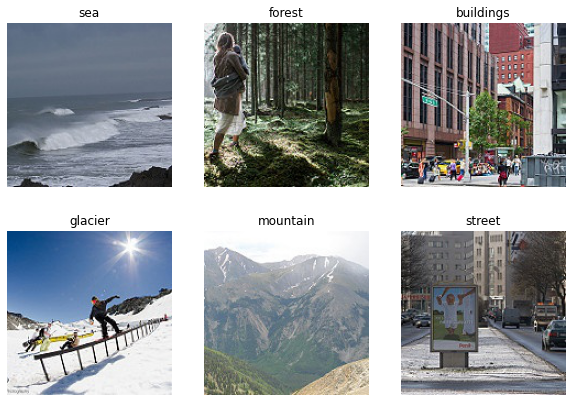

In [30]:
# Imagenes muestra de cada categoría 
plt.figure(figsize=(10, 7))
for i, folder in enumerate(os.listdir(train_dir)):
    ax = plt.subplot(2, 3, i + 1)
    img = plt.imread(train_dir+folder +'/'+ os.listdir(train_dir+folder)[0])
    plt.imshow(img)
    plt.title(folder)
    plt.axis("off")

Haremos un modelo inicial simple y sin previo preprocesamiento de las imágenes solo para ver el comportamiento de la clasificación así, con la hipotésis de que no se obtendrán los mejores resultados posibles. 



In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Train dataset
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_dataset  = train_data_gen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True, 
                                                    seed=21)

# Validation dataset
val_data_gen  = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_dataset = val_data_gen.flow_from_directory(validation_dir,
                                                      target_size=(150, 150),
                                                      color_mode='rgb',
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      shuffle=False,
                                                      seed=21)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [32]:
from tensorflow import keras 
from keras import layers

# Modelo inicial 
model = keras.Sequential([keras.Input(shape=(150, 150, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(6, activation='softmax')])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 34, 128)      

In [33]:
#Optimizador y métricas
opt = tf.keras.optimizers.Adam(learning_rate=.0005)
acc = tf.keras.metrics.CategoricalAccuracy()

model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = acc,
              )

In [34]:
# Guardar mejor modelo y detener el modelo en base a la pérdida en validación
mc= keras.callbacks.ModelCheckpoint(
        filepath="weights",
        save_best_only=True,
        monitor="val_loss")
es = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

with tf.device('/device:GPU:0'):
  #Entrenamiento
  history = model.fit(
      train_dataset,
      epochs=30,
      validation_data=validation_dataset,
      callbacks=[mc,es])

Epoch 1/30
438/439 [============================>.] - ETA: 0s - loss: 1.2270 - categorical_accuracy: 0.5138

439/439 [==============================] - 24s 55ms/step - loss: 1.2269 - categorical_accuracy: 0.5138 - val_loss: 1.0275 - val_categorical_accuracy: 0.5760
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 0.9856 - categorical_accuracy: 0.6149

439/439 [==============================] - 25s 56ms/step - loss: 0.9856 - categorical_accuracy: 0.6149 - val_loss: 0.9320 - val_categorical_accuracy: 0.6410
Epoch 3/30
438/439 [============================>.] - ETA: 0s - loss: 0.8658 - categorical_accuracy: 0.6634

439/439 [==============================] - 23s 52ms/step - loss: 0.8654 - categorical_accuracy: 0.6633 - val_loss: 0.7994 - val_categorical_accuracy: 0.6870
Epoch 4/30
439/439 [==============================] - ETA: 0s - loss: 0.7911 - categorical_accuracy: 0.6940

439/439 [==============================] - 23s 52ms/step - loss: 0.7911 - categorical_accuracy: 0.6940 - val_loss: 0.7410 - val_categorical_accuracy: 0.7153
Epoch 5/30
439/439 [==============================] - ETA: 0s - loss: 0.7292 - categorical_accuracy: 0.7204

439/439 [==============================] - 23s 53ms/step - loss: 0.7292 - categorical_accuracy: 0.7204 - val_loss: 0.7065 - val_categorical_accuracy: 0.7243
Epoch 6/30
439/439 [==============================] - 22s 50ms/step - loss: 0.6907 - categorical_accuracy: 0.7361 - val_loss: 0.7468 - val_categorical_accuracy: 0.7110
Epoch 7/30
439/439 [==============================] - 22s 50ms/step - loss: 0.6497 - categorical_accuracy: 0.7540 - val_loss: 0.7174 - val_categorical_accuracy: 0.7413
Epoch 8/30
439/439 [==============================] - ETA: 0s - loss: 0.6200 - categorical_accuracy: 0.7689

439/439 [==============================] - 23s 53ms/step - loss: 0.6200 - categorical_accuracy: 0.7689 - val_loss: 0.7007 - val_categorical_accuracy: 0.7383
Epoch 9/30
438/439 [============================>.] - ETA: 0s - loss: 0.5683 - categorical_accuracy: 0.7872

439/439 [==============================] - 23s 53ms/step - loss: 0.5683 - categorical_accuracy: 0.7875 - val_loss: 0.6533 - val_categorical_accuracy: 0.7593
Epoch 10/30
439/439 [==============================] - 24s 55ms/step - loss: 0.5341 - categorical_accuracy: 0.8033 - val_loss: 0.7239 - val_categorical_accuracy: 0.7333
Epoch 11/30
439/439 [==============================] - 22s 51ms/step - loss: 0.4859 - categorical_accuracy: 0.8244 - val_loss: 0.7288 - val_categorical_accuracy: 0.7537
Epoch 12/30
439/439 [==============================] - 22s 51ms/step - loss: 0.4435 - categorical_accuracy: 0.8394 - val_loss: 0.7161 - val_categorical_accuracy: 0.7507
Epoch 13/30
439/439 [==============================] - 22s 50ms/step - loss: 0.3902 - categorical_accuracy: 0.8597 - val_loss: 0.7486 - val_categorical_accuracy: 0.7377
Epoch 14/30
439/439 [==============================] - 22s 50ms/step - loss: 0.3417 - categorical_accuracy: 0.8770 - val_loss: 0.7537 - val_categorical_accuracy: 0.765

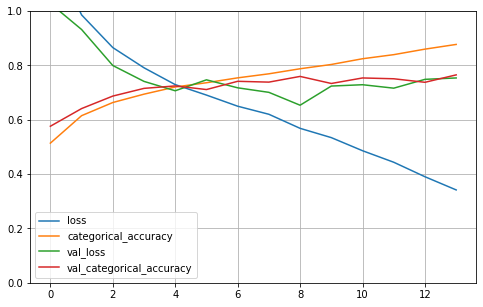

In [35]:
#Gráfica de linea de aprendizaje 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show(); 

Como podemos observar en la gráfica empieza a haber un overfitt que causa una gran separación entre la péridad del conjunto de entrenamiento y el de validación. También el valor de la exactitud de predición con respecto de cada conjunto se distancia y en la validación podemos ver como no mejora mucho del 75%. 

In [36]:
from tensorflow.keras.preprocessing import image

#Función para clasificar una imagen y regresar su etiqueta de clase predecida
def classify(img_path, model):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    #Predicción
    prediction = model.predict(img_preprocessed)
    prediction = np.argmax(prediction, axis=1)
    #Etiquetas
    labels = [k for k,v in train_dataset.class_indices.items()]
    label_pred = [labels[k] for k in prediction]
    return label_pred[0]   

1/1 [==============================] - 0s 22ms/step


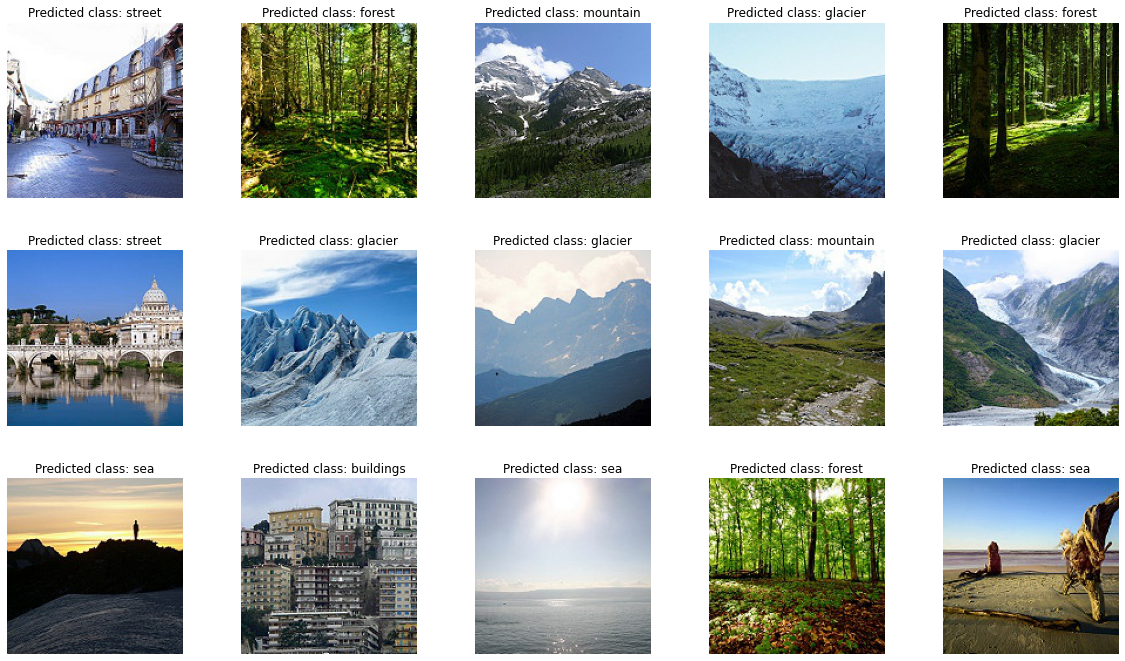

In [37]:
# 15 predicciones del conjunto de imagenes de predicción
plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    image_path = prediction_dir + random.choice(os.listdir(prediction_dir))
    prediction = classify(image_path,model)
    plt.imshow(plt.imread(image_path))
    plt.title(f'Predicted class: {prediction}')
    plt.axis("off")

Realizamos algunas predicciones con este modelo y de 15 imagenes podemos ver que clasificó correctamente 9/15, por lo tanto tuvo 6/15 erróneas. 

Haremos algunos cambios al modelo para ver si mejora el desempeño añadiendo algunas partes referentes a "data augmentation" , pero sin cambiar la arquitectura original de la red

In [38]:
# Modelo inicial
model = keras.Sequential([keras.Input(shape=(150, 150, 3)),
                          layers.RandomFlip("horizontal"), #DA
                          layers.RandomRotation(0.1), #DA
                          layers.RandomZoom(0.2), #DA
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(6, activation='softmax')])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                 

In [39]:
# Optimizador y métricas
opt = tf.keras.optimizers.Adam(learning_rate=.0005)
acc = tf.keras.metrics.CategoricalAccuracy()

model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = acc)

In [40]:
# Guardar mejor modelo y detener el modelo en base a la pérdida en validación
mc= keras.callbacks.ModelCheckpoint(
        filepath="weights",
        save_best_only=True,
        monitor="val_loss")
es = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

with tf.device('/device:GPU:0'):
  #Entrenamiento
  history2 = model.fit(
      train_dataset,
      epochs=30,
      validation_data=validation_dataset,
      callbacks=[mc,es])

Epoch 1/30
438/439 [============================>.] - ETA: 0s - loss: 1.4064 - categorical_accuracy: 0.4302

439/439 [==============================] - 39s 87ms/step - loss: 1.4059 - categorical_accuracy: 0.4303 - val_loss: 1.1559 - val_categorical_accuracy: 0.5250
Epoch 2/30
438/439 [============================>.] - ETA: 0s - loss: 1.1428 - categorical_accuracy: 0.5543

439/439 [==============================] - 36s 82ms/step - loss: 1.1425 - categorical_accuracy: 0.5545 - val_loss: 0.9948 - val_categorical_accuracy: 0.6147
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 1.0367 - categorical_accuracy: 0.5979

439/439 [==============================] - 37s 84ms/step - loss: 1.0367 - categorical_accuracy: 0.5979 - val_loss: 0.9058 - val_categorical_accuracy: 0.6690
Epoch 4/30
439/439 [==============================] - 34s 78ms/step - loss: 0.9738 - categorical_accuracy: 0.6296 - val_loss: 0.9210 - val_categorical_accuracy: 0.6437
Epoch 5/30
439/439 [==============================] - 35s 79ms/step - loss: 0.9315 - categorical_accuracy: 0.6465 - val_loss: 0.9878 - val_categorical_accuracy: 0.6270
Epoch 6/30
438/439 [============================>.] - ETA: 0s - loss: 0.9022 - categorical_accuracy: 0.6603

439/439 [==============================] - 36s 83ms/step - loss: 0.9025 - categorical_accuracy: 0.6605 - val_loss: 0.7949 - val_categorical_accuracy: 0.7020
Epoch 7/30
438/439 [============================>.] - ETA: 0s - loss: 0.8529 - categorical_accuracy: 0.6811

439/439 [==============================] - 37s 83ms/step - loss: 0.8529 - categorical_accuracy: 0.6811 - val_loss: 0.7732 - val_categorical_accuracy: 0.7167
Epoch 8/30
438/439 [============================>.] - ETA: 0s - loss: 0.8205 - categorical_accuracy: 0.6933

439/439 [==============================] - 37s 85ms/step - loss: 0.8206 - categorical_accuracy: 0.6934 - val_loss: 0.7313 - val_categorical_accuracy: 0.7357
Epoch 9/30
439/439 [==============================] - 36s 83ms/step - loss: 0.7918 - categorical_accuracy: 0.7074 - val_loss: 0.7556 - val_categorical_accuracy: 0.7247
Epoch 10/30
438/439 [============================>.] - ETA: 0s - loss: 0.7542 - categorical_accuracy: 0.7228

439/439 [==============================] - 36s 83ms/step - loss: 0.7546 - categorical_accuracy: 0.7227 - val_loss: 0.6948 - val_categorical_accuracy: 0.7463
Epoch 11/30
439/439 [==============================] - 34s 78ms/step - loss: 0.7382 - categorical_accuracy: 0.7270 - val_loss: 0.7189 - val_categorical_accuracy: 0.7360
Epoch 12/30
438/439 [============================>.] - ETA: 0s - loss: 0.7178 - categorical_accuracy: 0.7363

439/439 [==============================] - 37s 83ms/step - loss: 0.7177 - categorical_accuracy: 0.7365 - val_loss: 0.6779 - val_categorical_accuracy: 0.7540
Epoch 13/30
438/439 [============================>.] - ETA: 0s - loss: 0.6949 - categorical_accuracy: 0.7429

439/439 [==============================] - 37s 84ms/step - loss: 0.6947 - categorical_accuracy: 0.7431 - val_loss: 0.6384 - val_categorical_accuracy: 0.7690
Epoch 14/30
439/439 [==============================] - 35s 79ms/step - loss: 0.6843 - categorical_accuracy: 0.7533 - val_loss: 0.6563 - val_categorical_accuracy: 0.7627
Epoch 15/30
439/439 [==============================] - 34s 78ms/step - loss: 0.6828 - categorical_accuracy: 0.7534 - val_loss: 0.6483 - val_categorical_accuracy: 0.7590
Epoch 16/30
438/439 [============================>.] - ETA: 0s - loss: 0.6544 - categorical_accuracy: 0.7611

439/439 [==============================] - 36s 82ms/step - loss: 0.6548 - categorical_accuracy: 0.7610 - val_loss: 0.6339 - val_categorical_accuracy: 0.7663
Epoch 17/30
439/439 [==============================] - 36s 83ms/step - loss: 0.6372 - categorical_accuracy: 0.7715 - val_loss: 0.6446 - val_categorical_accuracy: 0.7590
Epoch 18/30
438/439 [============================>.] - ETA: 0s - loss: 0.6180 - categorical_accuracy: 0.7747

439/439 [==============================] - 36s 83ms/step - loss: 0.6176 - categorical_accuracy: 0.7750 - val_loss: 0.5906 - val_categorical_accuracy: 0.7863
Epoch 19/30
439/439 [==============================] - 34s 78ms/step - loss: 0.6217 - categorical_accuracy: 0.7725 - val_loss: 0.6384 - val_categorical_accuracy: 0.7633
Epoch 20/30
439/439 [==============================] - 34s 78ms/step - loss: 0.5937 - categorical_accuracy: 0.7860 - val_loss: 0.5971 - val_categorical_accuracy: 0.7880
Epoch 21/30
439/439 [==============================] - 34s 78ms/step - loss: 0.5838 - categorical_accuracy: 0.7883 - val_loss: 0.5965 - val_categorical_accuracy: 0.7823
Epoch 22/30
438/439 [============================>.] - ETA: 0s - loss: 0.5752 - categorical_accuracy: 0.7889

439/439 [==============================] - 36s 81ms/step - loss: 0.5755 - categorical_accuracy: 0.7890 - val_loss: 0.5894 - val_categorical_accuracy: 0.7820
Epoch 23/30
438/439 [============================>.] - ETA: 0s - loss: 0.5710 - categorical_accuracy: 0.7947

439/439 [==============================] - 35s 81ms/step - loss: 0.5711 - categorical_accuracy: 0.7946 - val_loss: 0.5875 - val_categorical_accuracy: 0.7967
Epoch 24/30
439/439 [==============================] - ETA: 0s - loss: 0.5529 - categorical_accuracy: 0.7993

439/439 [==============================] - 36s 82ms/step - loss: 0.5529 - categorical_accuracy: 0.7993 - val_loss: 0.5821 - val_categorical_accuracy: 0.7947
Epoch 25/30
439/439 [==============================] - 36s 82ms/step - loss: 0.5583 - categorical_accuracy: 0.7976 - val_loss: 0.6274 - val_categorical_accuracy: 0.7683
Epoch 26/30
439/439 [==============================] - 34s 78ms/step - loss: 0.5429 - categorical_accuracy: 0.8080 - val_loss: 0.6016 - val_categorical_accuracy: 0.7833
Epoch 27/30
438/439 [============================>.] - ETA: 0s - loss: 0.5254 - categorical_accuracy: 0.8120

439/439 [==============================] - 36s 82ms/step - loss: 0.5253 - categorical_accuracy: 0.8122 - val_loss: 0.5531 - val_categorical_accuracy: 0.8003
Epoch 28/30
438/439 [============================>.] - ETA: 0s - loss: 0.5243 - categorical_accuracy: 0.8097

439/439 [==============================] - 36s 82ms/step - loss: 0.5245 - categorical_accuracy: 0.8097 - val_loss: 0.5498 - val_categorical_accuracy: 0.8037
Epoch 29/30
439/439 [==============================] - 34s 78ms/step - loss: 0.5149 - categorical_accuracy: 0.8154 - val_loss: 0.5909 - val_categorical_accuracy: 0.7867
Epoch 30/30
439/439 [==============================] - 34s 78ms/step - loss: 0.5091 - categorical_accuracy: 0.8170 - val_loss: 0.5536 - val_categorical_accuracy: 0.8030


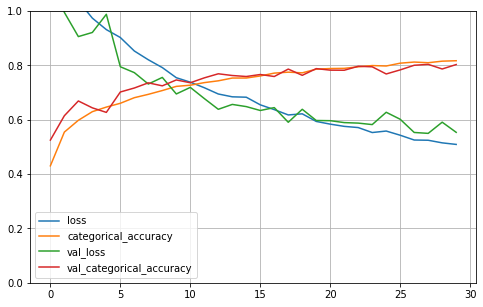

In [41]:
#Gráfica de linea de aprendizaje 
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show(); 

Podemos ver que el entrenamiento fue más largo que la versión previa, acompletando las 30 épocas, sin embargo la pérdida siguen sin tener los mejores resultados pero el comportamiento del aprendizaje en general es mejor. El acurracy logra llegar al 80% y no hay un overfitt tan elevado. 

1/1 [==============================] - 0s 17ms/step


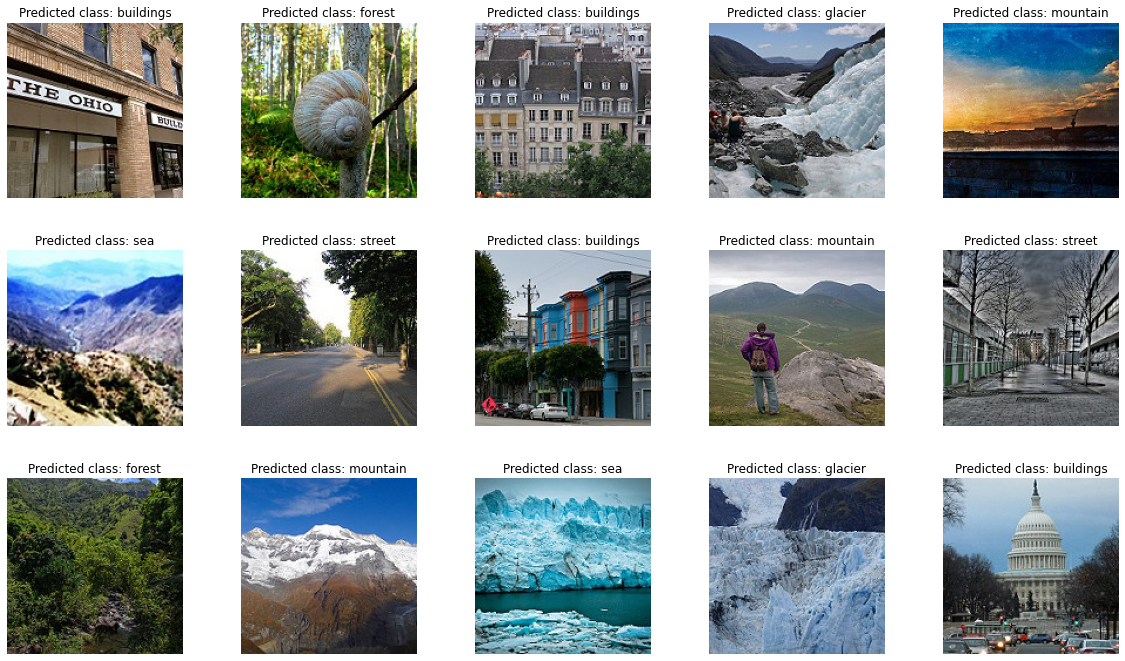

In [42]:
# 15 predicciones del conjunto de imagenes de predicción
plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    image_path = prediction_dir + random.choice(os.listdir(prediction_dir))
    prediction = classify(image_path,model)
    plt.imshow(plt.imread(image_path))
    plt.title(f'Predicted class: {prediction}')
    plt.axis("off")

En este conjunto de predicciones podemos apreciar como ha mejorado el desempeño clasificando correctamente 12/15 , equivocandose en tan solo 3/15.

Con el objetivo de mejorar aún más el modelo aplicaremos un preprocesamiento diferente a las imagenes, fuera del modelo, y aplicaremos más cambios a la arquitectura incluyendo dropout para intentar evitar el overfitt. 

In [9]:
#Train dataset
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True, 
                                    rotation_range=20,
                                    zoom_range=0.2, 
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2)
train_dataset_2 = train_data_gen.flow_from_directory(train_dir,
                                                     target_size=(150, 150),
                                                     color_mode='rgb',
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     shuffle=True, 
                                                     seed=21)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [18]:
# Modelo inicial
'''Cabe mencionar que probe el uso de batch normalization, pero debido a la similitud entre algunas clases no obtuvo resultados favorables, 
aún así se probo el uso como se muestra a continuación'''
model = keras.Sequential([keras.Input(shape=(150, 150, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          #layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          #layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          #layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          #layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dropout(0.4),
                          layers.Dense(6, activation='softmax')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 128)      

In [19]:
# Optimizador y métricas
opt = tf.keras.optimizers.Adam(learning_rate=.0005)
acc = tf.keras.metrics.CategoricalAccuracy()

model.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics = acc)

In [21]:
# Guardar mejor modelo y detener el modelo en base a la pérdida en validación
mc= keras.callbacks.ModelCheckpoint(
        filepath="weights",
        save_best_only=True,
        monitor="val_loss")
es = keras.callbacks.EarlyStopping(patience=7, monitor='val_loss')

with tf.device('/device:GPU:0'):
  #Entrenamiento
  history3 = model.fit(
      train_dataset_2,
      epochs=30,
      validation_data=validation_dataset_2,
      callbacks=[mc,es])

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 0.9027 - categorical_accuracy: 0.6537

439/439 [==============================] - 84s 191ms/step - loss: 0.9027 - categorical_accuracy: 0.6537 - val_loss: 0.7493 - val_categorical_accuracy: 0.7203
Epoch 2/30
439/439 [==============================] - 82s 187ms/step - loss: 0.8774 - categorical_accuracy: 0.6652 - val_loss: 0.7821 - val_categorical_accuracy: 0.7157
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.8489 - categorical_accuracy: 0.6795

439/439 [==============================] - 82s 186ms/step - loss: 0.8489 - categorical_accuracy: 0.6795 - val_loss: 0.6875 - val_categorical_accuracy: 0.7480
Epoch 4/30
439/439 [==============================] - 81s 185ms/step - loss: 0.8211 - categorical_accuracy: 0.6884 - val_loss: 0.7167 - val_categorical_accuracy: 0.7347
Epoch 5/30
439/439 [==============================] - ETA: 0s - loss: 0.7890 - categorical_accuracy: 0.7057

439/439 [==============================] - 84s 191ms/step - loss: 0.7890 - categorical_accuracy: 0.7057 - val_loss: 0.6361 - val_categorical_accuracy: 0.7700
Epoch 6/30
439/439 [==============================] - 81s 184ms/step - loss: 0.7809 - categorical_accuracy: 0.7131 - val_loss: 0.7528 - val_categorical_accuracy: 0.7247
Epoch 7/30
439/439 [==============================] - ETA: 0s - loss: 0.7485 - categorical_accuracy: 0.7200

439/439 [==============================] - 82s 186ms/step - loss: 0.7485 - categorical_accuracy: 0.7200 - val_loss: 0.6220 - val_categorical_accuracy: 0.7703
Epoch 8/30
439/439 [==============================] - 83s 188ms/step - loss: 0.7460 - categorical_accuracy: 0.7247 - val_loss: 0.6883 - val_categorical_accuracy: 0.7510
Epoch 9/30
439/439 [==============================] - ETA: 0s - loss: 0.7239 - categorical_accuracy: 0.7339

439/439 [==============================] - 82s 186ms/step - loss: 0.7239 - categorical_accuracy: 0.7339 - val_loss: 0.6190 - val_categorical_accuracy: 0.7803
Epoch 10/30
439/439 [==============================] - ETA: 0s - loss: 0.7075 - categorical_accuracy: 0.7394

439/439 [==============================] - 82s 186ms/step - loss: 0.7075 - categorical_accuracy: 0.7394 - val_loss: 0.5787 - val_categorical_accuracy: 0.7940
Epoch 11/30
439/439 [==============================] - 81s 185ms/step - loss: 0.7068 - categorical_accuracy: 0.7406 - val_loss: 0.7041 - val_categorical_accuracy: 0.7487
Epoch 12/30
439/439 [==============================] - 83s 188ms/step - loss: 0.6906 - categorical_accuracy: 0.7438 - val_loss: 0.5908 - val_categorical_accuracy: 0.7853
Epoch 13/30
439/439 [==============================] - 80s 183ms/step - loss: 0.6703 - categorical_accuracy: 0.7547 - val_loss: 0.5799 - val_categorical_accuracy: 0.7910
Epoch 14/30
439/439 [==============================] - 80s 183ms/step - loss: 0.6716 - categorical_accuracy: 0.7542 - val_loss: 0.6246 - val_categorical_accuracy: 0.7750
Epoch 15/30
439/439 [==============================] - ETA: 0s - loss: 0.6580 - categorical_accuracy: 0.7578

439/439 [==============================] - 83s 190ms/step - loss: 0.6580 - categorical_accuracy: 0.7578 - val_loss: 0.5548 - val_categorical_accuracy: 0.8000
Epoch 16/30
439/439 [==============================] - 81s 183ms/step - loss: 0.6496 - categorical_accuracy: 0.7624 - val_loss: 0.5629 - val_categorical_accuracy: 0.7970
Epoch 17/30
439/439 [==============================] - 80s 182ms/step - loss: 0.6399 - categorical_accuracy: 0.7661 - val_loss: 0.5813 - val_categorical_accuracy: 0.7883
Epoch 18/30
439/439 [==============================] - 82s 187ms/step - loss: 0.6391 - categorical_accuracy: 0.7678 - val_loss: 0.6631 - val_categorical_accuracy: 0.7543
Epoch 19/30
439/439 [==============================] - ETA: 0s - loss: 0.6262 - categorical_accuracy: 0.7693

439/439 [==============================] - 81s 185ms/step - loss: 0.6262 - categorical_accuracy: 0.7693 - val_loss: 0.5147 - val_categorical_accuracy: 0.8140
Epoch 20/30
439/439 [==============================] - 80s 183ms/step - loss: 0.6153 - categorical_accuracy: 0.7776 - val_loss: 0.5281 - val_categorical_accuracy: 0.8047
Epoch 21/30
439/439 [==============================] - 81s 184ms/step - loss: 0.6112 - categorical_accuracy: 0.7716 - val_loss: 0.5542 - val_categorical_accuracy: 0.8017
Epoch 22/30
439/439 [==============================] - ETA: 0s - loss: 0.6066 - categorical_accuracy: 0.7777

439/439 [==============================] - 83s 190ms/step - loss: 0.6066 - categorical_accuracy: 0.7777 - val_loss: 0.5132 - val_categorical_accuracy: 0.8053
Epoch 23/30
439/439 [==============================] - ETA: 0s - loss: 0.5974 - categorical_accuracy: 0.7812

439/439 [==============================] - 81s 185ms/step - loss: 0.5974 - categorical_accuracy: 0.7812 - val_loss: 0.4849 - val_categorical_accuracy: 0.8217
Epoch 24/30
439/439 [==============================] - 81s 183ms/step - loss: 0.5889 - categorical_accuracy: 0.7857 - val_loss: 0.5124 - val_categorical_accuracy: 0.8170
Epoch 25/30
439/439 [==============================] - ETA: 0s - loss: 0.5904 - categorical_accuracy: 0.7872

439/439 [==============================] - 84s 191ms/step - loss: 0.5904 - categorical_accuracy: 0.7872 - val_loss: 0.4777 - val_categorical_accuracy: 0.8237
Epoch 26/30
439/439 [==============================] - 81s 183ms/step - loss: 0.5791 - categorical_accuracy: 0.7885 - val_loss: 0.5312 - val_categorical_accuracy: 0.8053
Epoch 27/30
439/439 [==============================] - 81s 184ms/step - loss: 0.5717 - categorical_accuracy: 0.7884 - val_loss: 0.4841 - val_categorical_accuracy: 0.8253
Epoch 28/30
439/439 [==============================] - 82s 187ms/step - loss: 0.5708 - categorical_accuracy: 0.7915 - val_loss: 0.4946 - val_categorical_accuracy: 0.8233
Epoch 29/30
439/439 [==============================] - 80s 182ms/step - loss: 0.5697 - categorical_accuracy: 0.7944 - val_loss: 0.5056 - val_categorical_accuracy: 0.8187
Epoch 30/30
439/439 [==============================] - 81s 183ms/step - loss: 0.5578 - categorical_accuracy: 0.7964 - val_loss: 0.5091 - val_categorical_accuracy:

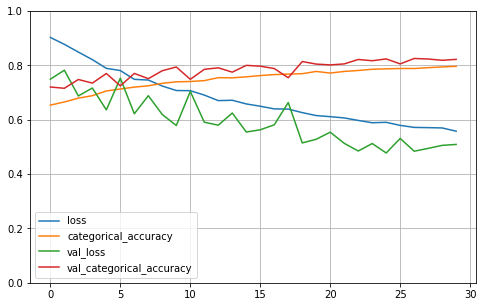

In [22]:
#Gráfica de linea de aprendizaje 
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show(); 

Como podemos observar el acurracy del set de validación logró mejorar llegando al 82%, y la perdida tuvo un mejor comportamiento que en los modelos previos. Algo un tanto curioso de esta línea de aprendizaje es que la exactitud del conjunto de validación obtuvo un puntaje más alto que el de entrenamiento. 

1/1 [==============================] - 0s 22ms/step


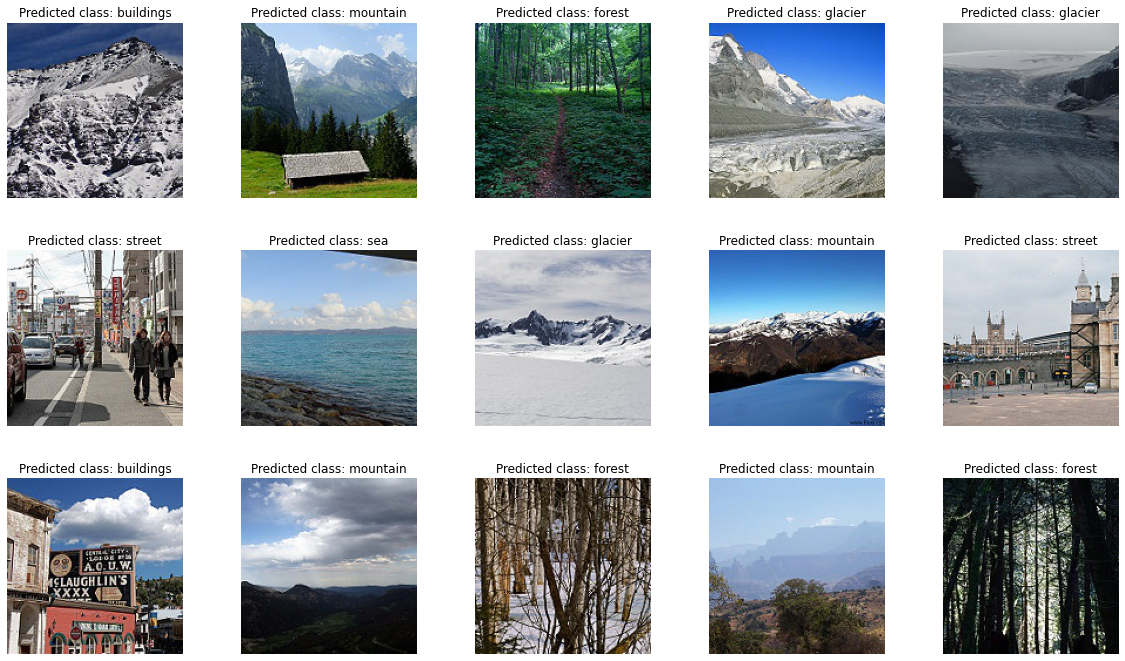

In [26]:
# 15 predicciones del conjunto de imagenes de predicción
plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    image_path = prediction_dir + random.choice(os.listdir(prediction_dir))
    prediction = classify(image_path,model)
    plt.imshow(plt.imread(image_path))
    plt.title(f'Predicted class: {prediction}')
    plt.axis("off")

Finalmente en este conjunto de predicciones podemos ver que obtuvo 14/15 correctas, con tan solo 1 error. 

A mi parecer este es un resultado favorable considerando las dimensiones del set de datos y que hay imagenes que no necesariamente retratan su categoría como 'sea' que tiene algunas imágenes de gaviotas y en edificios hay algunas que incluyen parte de calles e inversamente.